# Imports

In [1]:
# import library
%run lib.ipynb

from scipy import stats
from scipy.stats import yulesimon

# Generate data (yulesimon)

In [2]:
def sample_yulesimon(alpha, size):
    return yulesimon.rvs(alpha, loc=0, size=size)

def next_alpha(min_alpha=2.0, max_alpha=3.0):
    return np.random.uniform(low=min_alpha, high=max_alpha, size=1)[0]

# generate data (yulesimon)
def generate_data_yulesimon(N, M, density=False):
    raw, H, alphas = generate_data(N=N, M=M, nextConfig=next_alpha, sample=sample_yulesimon, density=density)

    # split train/test
    # (use train_test_split so the shape of the train/test data will be the same)
    H_train, H_test, y_train, y_test = train_test_split(H, alphas, test_size=0.25)
    
    return H_train, y_train, H_test, y_test

## Plot sample data

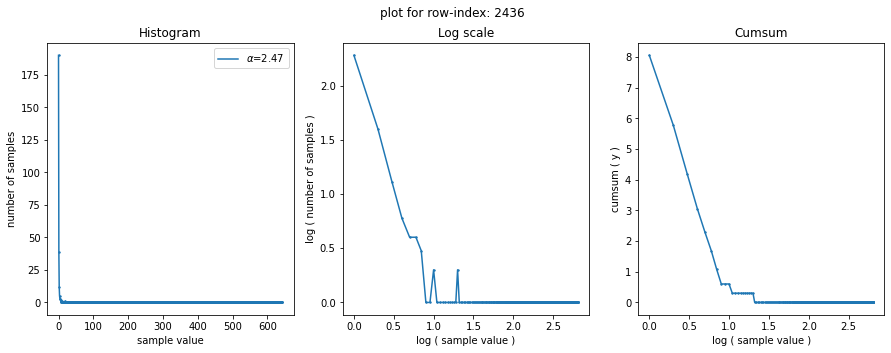

In [3]:
# plot helper function
def plot_histogram_logscale_cumsum(H, alphas):
    """
    plot data:
        - histogram
        - log scale
        - cumsum
    """
    # two plots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # select random row index
    ROW_INDEX_TO_PLOT = random.randint(0, H.shape[0] - 1)
    fig.suptitle(f'plot for row-index: {ROW_INDEX_TO_PLOT}')

    # plot histogram
    y = H[ROW_INDEX_TO_PLOT,:]
    x = np.array(range(len(y)))
    
    alpha = alphas[ROW_INDEX_TO_PLOT]

    ax1.set_title(f'Histogram')
    ax1.set_xlabel('sample value')
    ax1.set_ylabel('number of samples')
    ax1.scatter(x, y, zorder=1, s=2)
    ax1.plot(x, y, zorder=2, label=f'$α$={alpha:.2f}')
    ax1.legend()
    
    # plot log scale
    # (shift H values by one so as not to take log of zero)
    x = np.log10(x + 1)
    y = np.log10(y + 1)
    
    ax2.set_title('Log scale')
    ax2.set_xlabel('log ( sample value )')
    ax2.set_ylabel('log ( number of samples )')
    ax2.scatter(x, y, zorder=1, s=2)
    ax2.plot(x, y, zorder=2)

    # plot cumsum
    y = np.cumsum(y[::-1])[::-1]
    ax3.set_title('Cumsum')
    ax3.set_xlabel('log ( sample value )')
    ax3.set_ylabel('cumsum ( y )')
    ax3.scatter(x, y, zorder=1, s=2)
    ax3.plot(x, y, zorder=2)

# generate data
raw, H, alphas = generate_data(N=10000, M=256, nextConfig=next_alpha, sample=sample_yulesimon, density=False)

# plot single input row
plot_histogram_logscale_cumsum(H, alphas)

# Experiments

In [4]:
N = 10000

In [5]:
# shared function used in experiments
def Yulesimon_Experiment(X_train, y_train, X_test, y_test):

    start_time = time.time()
    dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test)
    train_time = round(time.time() - start_time)

    # debug print
    loss = np.min(history['loss'])
    val_loss = np.min(history['val_loss'])
    print(f'sqrt-mse: {sqrt_mse:.4f}', end=', ')
    #print(f'loss: {loss:.4f}', end=', ')
    #print(f'val_loss: {val_loss:.4f}', end=', ')
    print(f'train-time: {round(train_time)} sec.')

    trial = {
        'model': dnn_model,
        'history': history,
        'y-test': y_test,
        'y-pred': y_pred,
        'sqrt-mse': sqrt_mse,
        'train-time': train_time
    }

    return trial

## Experiment 1 - log vs. exact training
Run an experiment to show that using the log function improves something, either accuracy or learning rate, or both.
Use fixed setting, e.g, YS, samples = 256 or 512.
In this experiment use the LOG(1+X) function.

In [6]:
def experiment_1():
    
    trials = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [64, 128, 256, 512, 1024, 2048, 4096, 8192]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_yulesimon(N=N, M=M)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        for apply_log_scale in [True, False]:
            
            if apply_log_scale:
                X_train = log_scale(X_train)
                X_test = log_scale(X_test)
                print(f'training (log-scale={apply_log_scale}) ... ', end='')
            else:
                print(f'training (exact-values) ... ', end='')
            
            trial = Yulesimon_Experiment(X_train, y_train, X_test, y_test)
            
            trial['M'] = M
            trial['m'] = m
            
            trials.append(trial)
            
            sqrt_mse = trial['sqrt-mse']
            train_time = trial['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(apply_log_scale)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials, df

exp_1_trials, exp_1_df = experiment_1()


generating dataset (M=64) ... train input.shape: (7500, 795)
training (log-scale=True) ... sqrt-mse: 0.2552, train-time: 20 sec.
training (exact-values) ... sqrt-mse: 0.2586, train-time: 20 sec.

generating dataset (M=128) ... train input.shape: (7500, 295)
training (log-scale=True) ... sqrt-mse: 0.2415, train-time: 14 sec.
training (exact-values) ... sqrt-mse: 0.2431, train-time: 15 sec.

generating dataset (M=256) ... train input.shape: (7500, 1144)
training (log-scale=True) ... sqrt-mse: 0.2068, train-time: 25 sec.
training (exact-values) ... sqrt-mse: 0.2038, train-time: 24 sec.

generating dataset (M=512) ... train input.shape: (7500, 42027)
training (log-scale=True) ... sqrt-mse: 0.1717, train-time: 786 sec.
training (exact-values) ... sqrt-mse: 0.1765, train-time: 730 sec.

generating dataset (M=1024) ... train input.shape: (7500, 3661)
training (log-scale=True) ... sqrt-mse: 0.1432, train-time: 78 sec.
training (exact-values) ... sqrt-mse: 0.1370, train-time: 85 sec.

generati

,M,m,log-scale,sqrt-mse,train-time (sec.)
0,64,795,True,0.2552,20
1,64,795,False,0.2586,20
2,128,295,True,0.2415,14
3,128,295,False,0.2431,15
4,256,1144,True,0.2068,25
5,256,1144,False,0.2038,24
6,512,42027,True,0.1717,786
7,512,42027,False,0.1765,730
8,1024,3661,True,0.1432,78
9,1024,3661,False,0.1370,85


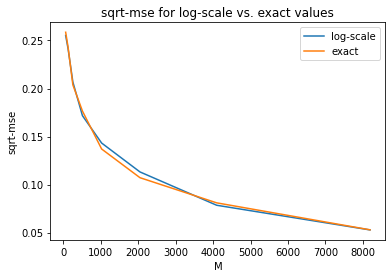

In [7]:
# plot sqrt-mse for log-scale vs. exact
def plot_log_scale_vs_exact(df):
    M_values = df.loc[df['log-scale'] == True][['M']].values
    sqrt_mse_log_scale = df.loc[df['log-scale'] == True][['sqrt-mse']].values
    sqrt_mse_exact = df.loc[df['log-scale'] == False][['sqrt-mse']].values
    _ = plt.plot(M_values, sqrt_mse_log_scale, label='log-scale')
    _ = plt.plot(M_values, sqrt_mse_exact, label='exact')
    plt.title('sqrt-mse for log-scale vs. exact values')
    plt.xlabel('M')
    plt.ylabel('sqrt-mse')
    _ = plt.legend()

plot_log_scale_vs_exact(exp_1_df)
exp_1_df

## Experiment 2 - log shift experiment
Run an experiment to see which C is better if using the function LOG(1+C)
Try, e.g., C = 0.2, 0.5, 1, 2,

In [8]:
# EXP_2_M_values = [256, 512, 1024, 2048]
EXP_2_M_values = [256, 512, 1024]

#EXP_2_C_values = [0.2, 0.5, 1.0, 2.0]
EXP_2_C_values = [0.2, 0.5, 1.0, 2.0]

def experiment_2():
    
    print(f'M_values: {EXP_2_M_values}')
    print(f'CM_values: {EXP_2_C_values}')
    
    trials = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'C': [], 
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in EXP_2_M_values:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_yulesimon(N=N, M=M, density=False)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        apply_log_scale = True
        
        for C in EXP_2_C_values:

            X_train = log_scale(X_train, C=C)
            X_test = log_scale(X_test, C=C)
            print(f'training (log-scale={apply_log_scale}, C={C} ) ... ', end='')
            
            trial = Yulesimon_Experiment(X_train, y_train, X_test, y_test)
            
            trial['M'] = M
            trial['m'] = m
            
            trials.append(trial)
            
            sqrt_mse = trial['sqrt-mse']
            train_time = trial['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(True)
            d['C'].append(1+C)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials, df

exp_2_trials, exp_2_df = experiment_2()

M_values: [256, 512, 1024]
CM_values: [0.2, 0.5, 1.0, 2.0]

generating dataset (M=256) ... train input.shape: (7500, 1345)
training (log-scale=True, C=0.2 ) ... sqrt-mse: 0.1993, train-time: 26 sec.
training (log-scale=True, C=0.5 ) ... sqrt-mse: 0.2470, train-time: 33 sec.
training (log-scale=True, C=1.0 ) ... sqrt-mse: 0.3970, train-time: 26 sec.
training (log-scale=True, C=2.0 ) ... sqrt-mse: 0.3582, train-time: 25 sec.

generating dataset (M=512) ... train input.shape: (7500, 1090)
training (log-scale=True, C=0.2 ) ... sqrt-mse: 0.1819, train-time: 23 sec.
training (log-scale=True, C=0.5 ) ... sqrt-mse: 0.2031, train-time: 25 sec.
training (log-scale=True, C=1.0 ) ... sqrt-mse: 0.2587, train-time: 32 sec.
training (log-scale=True, C=2.0 ) ... sqrt-mse: 0.2321, train-time: 30 sec.

generating dataset (M=1024) ... train input.shape: (7500, 5571)
training (log-scale=True, C=0.2 ) ... sqrt-mse: 0.1561, train-time: 107 sec.
training (log-scale=True, C=0.5 ) ... sqrt-mse: 0.1763, train-t

,M,m,log-scale,C,sqrt-mse,train-time (sec.)
0,256,1345,True,1.2,0.1993,26
1,256,1345,True,1.5,0.2470,33
2,256,1345,True,2.0,0.3970,26
3,256,1345,True,3.0,0.3582,25
4,512,1090,True,1.2,0.1819,23
5,512,1090,True,1.5,0.2031,25
6,512,1090,True,2.0,0.2587,32
7,512,1090,True,3.0,0.2321,30
8,1024,5571,True,1.2,0.1561,107
9,1024,5571,True,1.5,0.1763,88


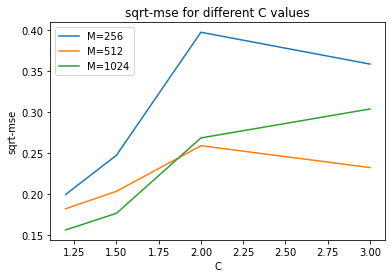

In [9]:
def plot_sqrt_mse_vs_C2(df, M_values):
    
    C_values = df.loc[df['M'] == M_values[0]][['C']].values
    for M in M_values:
        sqrt_mse_for_M = df.loc[df['M'] == M][['sqrt-mse']].values
        _ = plt.plot(C_values, sqrt_mse_for_M, label=f'M={M}')
        plt.xlabel('C')
        plt.ylabel('sqrt-mse')
    plt.title('sqrt-mse for different C values')
    _ = plt.legend()

plot_sqrt_mse_vs_C2(df=exp_2_df, M_values=EXP_2_M_values)
exp_2_df

## Experiment 3 - bias experiment
Same experiment as usual, but make sure the prediction is unbiased. Average difference should be close to zero

In [10]:
def test_bias(trials, df):
    d = {
        'M': [], 
        'm': [], 
        'log-scale': [],
        'sqrt-mse': [],
        'Bias': [],
    }

    for i in range(len(trials)):
        d['M'].append(trials[i]['M'])
        d['m'].append(trials[i]['m'])
        d['log-scale'].append(df['log-scale'][i])
        y_test = np.round(trials[i]['y-test'], decimals=2)
        y_pred = np.round(trials[i]['y-pred'], decimals=2)
        avg_diff = np.average(y_test - y_pred)
        d['Bias'].append(np.round(avg_diff, decimals=4))
        d['sqrt-mse'].append(np.round(trials[i]['sqrt-mse'], decimals=4))

    return pd.DataFrame(data=d)

df_bias_1 = test_bias(trials=exp_1_trials, df=exp_1_df)
df_bias_1

,M,m,log-scale,sqrt-mse,Bias
0,64,795,True,0.2552,-0.0318
1,64,795,False,0.2586,-0.0340
2,128,295,True,0.2415,0.0080
3,128,295,False,0.2431,-0.0051
4,256,1144,True,0.2068,0.0351
5,256,1144,False,0.2038,-0.0058
6,512,42027,True,0.1717,-0.0160
7,512,42027,False,0.1765,0.0183
8,1024,3661,True,0.1432,0.0133
9,1024,3661,False,0.1370,-0.0025
